# Evaluation of test year GCM-driven run

In [34]:
import valenspy as vp
from valenspy._utilities import load_yml
from valenspy.preprocessing_tasks.select import select_point
from valenspy.diagnostic_functions import mean_bias, mean_absolute_error, root_mean_square_error, spearman_correlation, perkins_skill_score, time_series_spatial_mean
from valenspy.diagnostic_visualizations import plot_time_series
from pathlib import Path

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd


# define machine name - used for paths of (observational) datasets
machine = 'hortense'

manager = vp.InputManager(machine=machine)


## TO DO
1. Add -10 at boundaries
2. Include checks for the extremes

## 0. Pre-defining 

In [35]:
# Define reference datasets
reference = 'ERA5'
test_set = 'EC-Earth'
domain = 'EUR11'
model = "CCLM"

variable = 'tas'
daily_statistic = "mean"

## 1. Functions

In [36]:
def load_data_exp(variable, model, experiment):

    if variable in ['tas','clt', 'clh', 'clm', 'cll']:
        daily_statistic = "mean"
    #    ds_exp = ds_obs.resample(time='1D').mean()

    elif variable == 'pr': 
 
        daily_statistic = "sum"
   #     ds_obs = ds_obs.resample(time='1D').sum()

    elif variable == "tasmax": 
        daily_statistic = "max"
       # ds_obs = ds_obs.resample(time='1D').max()

    ds_mod = manager.load_data(model, [variable], freq="hourly", path_identifiers=[experiment, daily_statistic])


    ds_mod['time'] = ds_mod['time'].dt.floor('D')


    da_exp = ds_mod[variable].compute()

    return da_exp

In [37]:
def plot_point_timeseries(variable: str, ref_dataset: str, experiments: list, point_coord: tuple, point_id:str,  months_to_analyse: list, ax=False): 
        
    # start up input manager
    manager = vp.InputManager(machine=machine)

    if ref_dataset=="ERA5": 
        region_to_load ="europe"
    elif ref_dataset=="ERA5-Land": 
        region_to_load = "belgium"

    # use input manager to load data, defined on settings above
    #ds_obs = manager.load_data(ref_dataset,variable, period=[1995,1995],freq="daily",region=region, path_identifiers = ["-daily-"])
    if ref_dataset == 'ERA5' or ref_dataset== 'ERA5-Land':

        if variable == 'tasmax':        
            variable_to_load = "tas"
            ds_obs = manager.load_data(ref_dataset,variable_to_load, period=[1995,1995],freq="hourly",region=region_to_load)
            ds_obs = ds_obs.resample(time='1D').max().rename({'tas':variable})


        elif variable == "tasmin": 
            variable_to_load = "tas"
            ds_obs = manager.load_data(ref_dataset,variable_to_load, period=[1995,1995],freq="hourly",region=region_to_load)
            ds_obs = ds_obs.resample(time='1D').min().rename({'tas':variable}) 

        elif variable == "pr": 
            ds_obs = manager.load_data(ref_dataset,variable, period=[1995,1995],freq="daily",region=region_to_load, path_identifiers=["sum"])
    
    elif ref_dataset == 'CLIMATE_GRID': 

        # use input manager to load data, defined on settings abov
        ds_obs = manager.load_data(ref_dataset,variable, path_identifiers=['latlon_5km'])

        # select corresponding year
        ds_obs = ds_obs.sel(time = ds_obs.time.dt.year.isin(1995))

        region = 'belgium'

    elif ref_dataset=='EOBS': 

        # use input manager to load data, defined on settings abov
        ds_obs = manager.load_data(ref_dataset,variable, path_identifiers=['0.1deg', 'mean'])
        ds_obs = ds_obs.sel(time = ds_obs.time.dt.year.isin(1995))

    
    # select point 
    ds_obs_point = select_point(ds_obs, point_coord)
    da_obs_point = ds_obs_point[variable].sel(time=ds_obs['time'].dt.month.isin(months_to_analyse))


    # generate path of CCLM output

    # dictorionary to save data arrays of experiments
    d_da_mod_point = {}

    for experiment in experiments: 


        # define the CCLM files for the corresponding variable
        if variable == "tasmax": 
            daily_statistic = "max"
            variable_mod = "tasmax"

        elif variable == "tasmin": 
            daily_statistic = "min"
            variable_mod = "tas"
        elif variable == "pr": 
            daily_statistic = "sum"
            variable_mod =  variable
        else: 
            daily_statistic = "mean"
            variable_mod = variable

        # load data
        ds_mod = manager.load_data(model, [variable_mod], freq="daily", path_identifiers=[experiment, daily_statistic])
        
        if variable =="tasmax" or variable =="tasmin": 
            ds_mod = ds_mod.rename({'tas':variable}) 

        # do selection
        ds_mod_point = select_point(ds_mod, point_coord, rotated_pole=True)

        da_mod_point = ds_mod_point[variable].sel(time=ds_mod['time'].dt.month.isin(months_to_analyse))

        d_da_mod_point[experiment] = da_mod_point

    # do plotting
    # when no ax element is passed, create the figure within the function
    if not ax: 
        fig, ax = plt.subplots(figsize = (7,3))

    if variable == 'pr': 
        da_obs_point = _convert_kg_m2s_to_mm_day(da_obs_point)
    da_obs_point.plot(ax=ax, label = ref_dataset, color='k')

    for experiment in d_da_mod_point: 
        if variable == 'pr': 
            d_da_mod_point[experiment] = _convert_kg_m2s_to_mm_day(d_da_mod_point[experiment])

        d_da_mod_point[experiment].plot(ax=ax, label = experiment, alpha=0.5)

    ax.set_title(' ', loc='center')
    ax.set_title(f"{point_id} ({point_coord[1]}°N,  {point_coord[0]}°E)", loc='right');
    ax.set_title(da_obs_point.attrs['long_name'], loc='left')

    # only add legend if stand-alone figure
    if not ax: 
        ax.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))

        
    return ax


## 2. Running

In [ ]:
experiment = "CB2_CCLM_EUR11_EC-Earth_test"
model = "CCLM"
variable = 'tas'
daily_statistic = "mean"
da_exp = manager.load_data(model, [variable], freq="monthly", path_identifiers=[experiment, daily_statistic])
da_exp

In [ ]:
experiment = "CB2_CCLM_EUR11_ERA5_evaluation"
model = "CCLM"

variable = 'tas'
daily_statistic = "mean"
da_eval = manager.load_data(model, [variable], period = [1980,2020], freq="monthly", path_identifiers=[experiment,daily_statistic])
da_eval
# for 3 years: took around 3.5 minutes: 3 for finding folder 20s for loading data

File paths found:
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_EUR11_ERA5_evaluation/CB2_CCLM_EUR11_ERA5_evaluation/T_2M/monthly/T_2M_daymean_198006.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_EUR11_ERA5_evaluation/CB2_CCLM_EUR11_ERA5_evaluation/T_2M/monthly/T_2M_daymean_198204.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_EUR11_ERA5_evaluation/CB2_CCLM_EUR11_ERA5_evaluation/T_2M/monthly/T_2M_daymean_198008.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_EUR11_ERA5_evaluation/CB2_CCLM_EUR11_ERA5_evaluation/T_2M/monthly/T_2M_daymean_198203.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_EUR11_ERA5_evaluation/CB2_CCLM_EUR11_ERA5_evaluation/T_2M/monthly/T_2M_daymean_198509.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_EUR11_ERA5_eval

<xarray.Dataset> Size: 2GB
Dimensions:       (time: 2192, bnds: 2, rlat: 434, rlon: 446)
Coordinates:
  * time          (time) datetime64[ns] 18kB 1980-01-01T11:30:00 ... 1985-12-...
    lon           (rlat, rlon) float32 774kB dask.array<chunksize=(434, 446), meta=np.ndarray>
    lat           (rlat, rlon) float32 774kB dask.array<chunksize=(434, 446), meta=np.ndarray>
  * rlon          (rlon) float32 2kB -29.58 -29.48 -29.36 ... 19.15 19.25 19.36
  * rlat          (rlat) float32 2kB -24.58 -24.48 -24.36 ... 22.83 22.93 23.05
    height_2m     float32 4B 2.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds     (time, bnds) datetime64[ns] 35kB dask.array<chunksize=(31, 2), meta=np.ndarray>
    rotated_pole  (time) |S1 2kB b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    tas           (time, rlat, rlon) float32 2GB dask.array<chunksize=(31, 434, 446), meta=np.ndarray>
Attributes: (12/19)
    CDI:               Climate Data Interface version 2.3.0 (https://mpimet.m...
    Conventions:       CF-1.4
    source:            cosmo6.00_clm2, int2lm3.0_clm1
    institution:       KU Leuven, Leuven, BELGIUM
    title:             CB2_CCLM_EUR11_ERA5_evaluation
    project_id:        CORDEXbe2
    ...                ...
    frequency:         day
    CDO:               Climate Data Operators version 2.3.0 (https://mpimet.m...
    freq:              monthly
    path_identifiers:  ['CB2_CCLM_EUR11_ERA5_evaluation', 'mean']
    dataset:           CCLM
    period:            [1980, 1985]

In [ ]:
from valenspy.preprocessing_tasks.select import select_region, select_point

# Define the coordinates
d_point_coords = {
    'opwijk'    : (4.18, 50.97), 
    'betrix'    : (5.25, 49.854),
    'north_sea' : (2.465, 51.63),
    'channel'   : (-1.05, 50.14)
}
point_coord = d_point_coords['opwijk']

#da_eval_grid = select_region(da_eval, region = "belgium")

#da_eval_timeseries = time_series_spatial_mean(da_eval_grid)

In [ ]:
ds_mean_eval = da_eval.mean(dim=["rlat", "rlon"])
# da_point_eval = select_point(da_eval, lon_lat_point = point_coord, rotated_pole = True)
# da_point_exp = select_point(da_exp, lon_lat_point = point_coord, rotated_pole = True)
ds_mean_exp = da_exp.mean(dim = ["rlat", "rlon"])
ds_mean_eval

<xarray.Dataset> Size: 64kB
Dimensions:       (time: 2192, bnds: 2)
Coordinates:
  * time          (time) datetime64[ns] 18kB 1980-01-01T11:30:00 ... 1985-12-...
    height_2m     float32 4B 2.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds     (time, bnds) datetime64[ns] 35kB dask.array<chunksize=(31, 2), meta=np.ndarray>
    rotated_pole  (time) |S1 2kB b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    tas           (time) float32 9kB dask.array<chunksize=(31,), meta=np.ndarray>
Attributes: (12/19)
    CDI:               Climate Data Interface version 2.3.0 (https://mpimet.m...
    Conventions:       CF-1.4
    source:            cosmo6.00_clm2, int2lm3.0_clm1
    institution:       KU Leuven, Leuven, BELGIUM
    title:             CB2_CCLM_EUR11_ERA5_evaluation
    project_id:        CORDEXbe2
    ...                ...
    frequency:         day
    CDO:               Climate Data Operators version 2.3.0 (https://mpimet.m...
    freq:              monthly
    path_identifiers:  ['CB2_CCLM_EUR11_ERA5_evaluation', 'mean']
    dataset:           CCLM
    period:            [1980, 1985]

In [ ]:
#ds_year = da_point_eval.sel(time=da_point_eval.time.dt.year.isin([1980]))
#pd.to_datetime(ds_year["time"]).strftime("%m-%d")

## 2. Calculation and visualisation of time series
in this example, the reference data is split up for each year. Each year is plot in a spaghetti plot, where the test year is also included.
Additionally, the P5, P50 and P95 of the reference data is included for every day of every year.

In [ ]:
def select_year(da : xr.Dataset, year: int):
    """
    Select single year in dataset

    """

In [ ]:
def get_spaghetti_GLUE(ds_eval: xr.Dataset, ds_exp: xr.Dataset, variable: str): 

    """
    Plots the yearly cycle for each year in the evaluation dataset (`da_eval`)
    and the experimental dataset (`da_exp`), starting on January 1st for all.

    Parameters:
        da_eval (xarray.Dataset): Evaluation dataset with multiple years.
        da_exp (xarray.Dataset): Experimental dataset with a single year.
        variable (str): The name of the variable to plot.

    Returns:
        None: Displays the plot.
    """
    plt.figure(figsize = (20,5))
    # Exctract unique years
    years_eval = np.unique(pd.to_datetime(ds_eval.time).year)
    years_exp = np.unique(pd.to_datetime(ds_exp.time).year)

    # # 1. Extract Day of Year (DOY)
    #da_eval = ds_eval[variable]
    #da_exp = ds_exp[variable]

    # da_eval['doy'] = da_eval['time'].dt.dayofyear
    # da_exp['doy'] = da_exp['time'].dt.dayofyear

    # # Loop over all years:
    for yr in years_eval:
        ds_year = ds_eval.sel(time=ds_eval.time.dt.year.isin([yr]))
        #ds_year = ds_eval.sel(time=slice(str(yr) + '-01-01', str(yr) + '-12-31'))
        #ds_year["time"] = pd.to_datetime(ds_year["time"]).strftime("%m-%d")
        print("In year " + str(yr) + ' we have ' + str(len(ds_year["time"])) + " datapoints.")
        da_year = ds_year[variable]
        df_year = da_year
        da_year["doy"] = da_year['time'].dt.dayofyear

        #plt.plot(da_year['doy'], da_year, label="Evaluation Dataset (" + str(len(years_eval)) + ")", color = "grey")

    for yr in years_exp:
        ds_year = ds_exp.sel(time=ds_exp.time.dt.year.isin([yr]))
        #ds_year = ds_exp.sel(time=slice(str(yr) + '-01-01', str(yr) + '-12-31'))
        #ds_year["time"] = pd.to_datetime(ds_year["time"]).strftime("%m-%d")
        print("In year " + str(yr) + ' we have ' + str(len(ds_year["time"])) + " datapoints.")
        da_year = ds_year[variable]
        df_year = da_year
        da_year["doy"] = da_year['time'].dt.dayofyear

        plt.plot(da_year['doy'], da_year, label="Experimental Dataset (" + str(len(years_exp)) + ")", color = "red")

    # # Ensure you are working with DataArrays
    # da_eval_var = da_eval[variable]
    # da_exp_var = da_exp[variable]

    # # Add 'year' and 'doy' coordinates
    # da_eval_var = da_eval_var.assign_coords(
    #     year=da_eval_var['time'].dt.year,
    #     doy=da_eval_var['time'].dt.dayofyear,
    # )
    # da_exp_var = da_exp_var.assign_coords(doy=da_exp_var['time'].dt.dayofyear)

    # # Group by year and DOY for evaluation dataset
    # grouped_eval = da_eval_var.groupby('year')

    # # Group by DOY for the experimental dataset
    # exp_yearly_cycle = da_exp_var.groupby('doy').mean(dim='time')

    # # Plot
    # plt.figure(figsize=(12, 6))

    # # Plot each year in the evaluation dataset as a separate line
    # for year, data in grouped_eval:
    #     yearly_cycle = data.groupby('doy').mean(dim='time')  # Cycle for this year
    #     plt.plot(yearly_cycle['doy'], yearly_cycle, label=f"Year {year}")

    # # Plot the experimental dataset
    # plt.plot(exp_yearly_cycle['doy'], exp_yearly_cycle, color='black', linestyle='--', linewidth=2, label="Experimental Dataset (1 year)")

    # Customize Plot
    plt.title(f"Yearly Cycle of {variable}")
    plt.xlabel("Day of Year")
    plt.ylabel(variable)
    plt.legend(loc='upper right', fontsize='small', ncol=2)  # Adjust legend
    plt.grid()
    plt.show()

    return da_year


In year 1980 we have 366 datapoints.
In year 1981 we have 365 datapoints.
In year 1982 we have 365 datapoints.
In year 1983 we have 365 datapoints.
In year 1984 we have 366 datapoints.
In year 1985 we have 365 datapoints.
In year 1995 we have 365 datapoints.


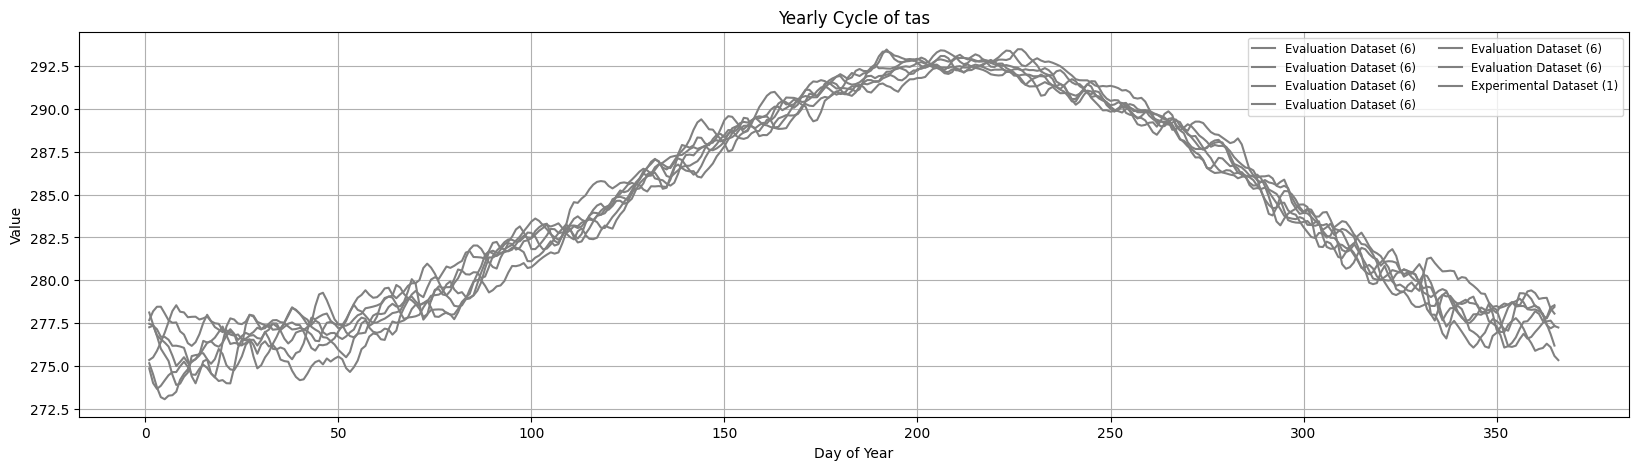

In [ ]:
ds_test = get_spaghetti_GLUE(ds_mean_eval, ds_mean_exp, variable = 'tas')


## 3. Calculation of P5, P50, P95 for each year 
In this example, the P5, P50 and P95 for each year are calculated for the reference run and the test year. 